The goal of this project is to train and compare several common Supervised Machine Learning models on the [1984 Congressional Voting Records Dataset](https://archive.ics.uci.edu/ml/datasets/congressional+voting+records "Congressional Voting Records Data Set"). 

The Machine Learning models used and compared here are several classifiers: K-Nearest Neighbors (KNN), Support-Vector Machine Classifier (SVC), Logistic Regression(LogReg), and the Random Forest Classifier. I learned to use these models from [Datacamp](http://www.datacamp.com)'s course on Supervised Learning, including training and evaluation of model performance. 

One common way to evaluate model performance is using the [Receiver Operating Characteristic Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) (or ROC). We'll go into more detail later, but this gives us quick overview of what model parameters can give optimal performance in terms of true positives and false positives.
<img src="https://illesial.github.io/images/ROC.png" alt="ROC Curve" width="360" align="center"/>
<!--excerpt-->

Each one of the models named above is meant to classify an observation. In this case, the observations are the voting records of members of the House of Representatives in 1984, and the desired classification is Party Affiliation - Republican or Democrat. 

Each model will be trained on a fraction of the dataset: a fraction of the voting records will be provided, along with the party affiliation of that voter. The models will then attempt to predict what the party affiliation is of the remaining data: based on the voting record of each congressional member, what party do they belong to?

We'll begin by importing packages, starting with pandas as pd and numpy as np. We'll also our import some models and tools from scikit-learn (`sklearn`), including `train_test_split`, `GridSearchCV`, and `classification_report`, among others. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### MODELS TO USE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# PARAMETER TUNING / CROSS VALIDATION TOOLS

from sklearn.model_selection import GridSearchCV

### MODEL EVALUATION METRICS TO USE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

Next, we'll load our data into a pandas dataframe df using `pd.read_csv()`. I've already cleaned the data ahead of time, and it's available in `house_reps_data.csv`.

In [2]:
df=pd.read_csv('house_reps_data\\house_reps_data.csv')

Next, we'll inspect the data using `df.head()`:

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


We see that each row corresponds to a member of Congress. The first column is party, and the rest of the columns record their vote: 1 for yes, 0 for no or abstain. 

Our goal is to predict, using several classification models, the party affiliation of a member of congress based on their voting record. To do so, we'll first need to split up our features `X` (the predictor variables) from our target variables `y`. We'll also need to convert our target variables, the party affiliation, to numerical data: 0 for republican and 1 for democrat. These steps are taken below.

In [3]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [4]:
y=y.apply(lambda x: {'republican': 0, 'democrat': 1}[x])

When creating a model, it's useful to split your data into training sets and testings sets. This helps us make sure our model behaves better for predicting unseen data. Therefore we use `train_test_split()` below, and use only 60% of our data to train, and reserve 40% for testing.

In [5]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

## Classification Models:
### 1) KNN
We proceed by training our first classification model on our voting data: K-Nearest Neighbors, or KNN. The way KNN works is that it groups points into classes based on their K-"closest" neighbors, where closest means Euclidean distance by default. 

How should we pick K? That is, how do we choose the number of neighbors to group together? Instead of picking values of K one at a time, we'll have python choose the best value of K, using `GridSearchCV`. This is called "hyper-"parameter tuning. Additionally, `GridSearchCV` will cross-validate; that is, it will split the data into training and validation sets multiple times, and test parameter values each time. In this way, `GridSearchCV` will better protect against overfitting while also choosing optimal parameters. Here, we'll have `GridSearchCV` determine the best value of K by trying each value from 1 to 49, and then we'll report the best model parameter and best model accuracy. Take note that the model parameter is actually denoted by the variable `n_neighbors` instead of K. 

In [6]:
# Create the hyperparameter grid
n_space = np.arange(1, 50)
param_grid = {'n_neighbors': n_space}

# Instantiate the logistic regression classifier
knn = KNeighborsClassifier()

# Instantiate the GridSearchCV object
knn_cv = GridSearchCV(knn, param_grid, cv = 5)

# Fit it to the training data
knn_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned KNN Parameter: {}".format(knn_cv.best_params_))
print("Tuned KNN Accuracy: {}".format(knn_cv.best_score_))


Tuned KNN Parameter: {'n_neighbors': 7}
Tuned KNN Accuracy: 0.9157088122605364


### KNN, Model evaluation:
What we see is the optimal number of neighbors is 7, with an accuracy of approxmately 0.92. 

Below, we make model predictions using the test data, and we grade our model using several popular model scores: precision, recall, and the f1-score. These scores take values between zero and one. If precision is close to one, it means that the model rarely made a "false positive", while if recall is close to one, it means that the model correctly identified nearly all positives. The f1-score combines both precision and recall; if the f1-score is close to one, the model had a high rate of correct classification. Support here is just the number of occurences of each class. Recall that we previously set 0 to Republican, and 1 to Democrat. 

In [7]:
y_pred_knn=knn_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[ 55   4]
 [  7 108]]
             precision    recall  f1-score   support

          0       0.89      0.93      0.91        59
          1       0.96      0.94      0.95       115

avg / total       0.94      0.94      0.94       174



The final model evaluation tool we'll use is the ROC curve, which stands for the Receiver Operating Characteristic curve. The ROC curve is a graph of the true positive rate vs the false positive rate as a classification probability threshold used in the model varies. A desirable ROC curve has high true positive rates at low false positive rates; visually, this corresponds to a high area under this curve. Hence, we have another heuristic model score called AUC, or area under the curve. 

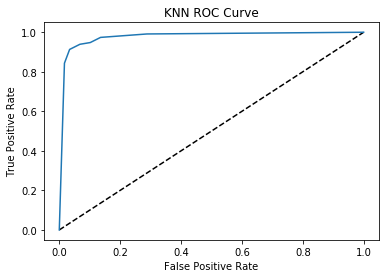

In [8]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

The AUC score for this model we calculate below:

In [12]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.9766396462785557


The AUC score is about 0.98, which is very good!

### 2) Random Forest Classifier:
Next, we'll train a Random Forest classifier on our data. A Random Forest classifier is a type of Decision Tree classifier. Decision tree classifiers work, and do so very accurately, by drawing many decision boundaries in order to classify the data. In fact, Decision trees are so flexible that they typically overfit. Although a Decision Tree may obtain a high accuracy score on its training data, there is no reason to expect this high accuracy will translate to new data. This overfitting can be combatted by training many Decision Trees on different parts of the training data, and aggregating the results. This is what is called a Random Forest, and the procedure that generates the random forest is frequently referred to as "bagging", or bootstrap aggregating. 

We'll implement the random forest below along with cross-validation and some parameter tuning. Here the model parameters are the number of estimators and the maximum number of features.

In [42]:
num_cols = len(X_train.columns)
n_est_space=np.array([round_to_int(x) for x in np.logspace(1, 1.5, num = 20)])
max_feat_space=np.arange(round_to_int(np.sqrt(num_cols) / 2), round_to_int(np.sqrt(num_cols) * 2) + 1)

param_grid_rf = {'n_estimators': n_est_space, 'max_features': max_feat_space}

rand_forest = RandomForestClassifier()

rand_forest_cv = GridSearchCV(rand_forest, param_grid_rf, cv = 5)
rand_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([10, 11, 11, 12, 13, 14, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26,
       28, 30, 32]), 'max_features': array([2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
print("Tuned Random Forest Parameters: {}".format(rand_forest_cv.best_params_))
print("Tuned Random Forest Accuracy: {}".format(rand_forest_cv.best_score_))

Tuned Random Forest Parameters: {'max_features': 3, 'n_estimators': 14}
Tuned Random Forest Accuracy: 0.9578544061302682


### Random Forest, Model evaluation:

It looks like the best model parameters are 14 estimators and a maximum number of features of 3. The accuracy is about 0.96, which is better than KNN. 

We again use our model to predict on the test data, and report precision, recall, and f1-scores. This time, however, we'll leave out the ROC curve and AUC score.

In [44]:
y_pred_rf = rand_forest_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[ 57   2]
 [  4 111]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95        59
          1       0.98      0.97      0.97       115

avg / total       0.97      0.97      0.97       174



The Random Forest again performs better than KNN; its f1-score is 0.97. 
### 3) SVC Classifier
The next model we'll train is the Support Vector Machine Classifier, or SVC for short. SVC attempts to classify the data by identifying a separating hyperplane; that is, it aims to find a linear boundary which separates the data into classes. This model has one regularization parameter, C, which allows the model to be more flexible (by breaking the decision boundary into pieces) at higher values. A value of C that is too high will lead to overfitting. Hence, we again use cross-validation and parameter tuning to identify the best value of this parameter. 

In [10]:
C_space = np.linspace(.2, 5, num=50)
param_grid_svc = {'C': C_space}

svc = SVC()

svc_cv = GridSearchCV(svc, param_grid_svc, cv = 5)
svc_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVC Parameter: {}".format(svc_cv.best_params_))
print("Tuned SVC Accuracy: {}".format(svc_cv.best_score_))

Tuned SVC Parameter: {'C': 3.726530612244898}
Tuned SVC Accuracy: 0.9540229885057471


In [11]:
y_pred_svc = svc_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

[[ 58   1]
 [  3 112]]
             precision    recall  f1-score   support

          0       0.95      0.98      0.97        59
          1       0.99      0.97      0.98       115

avg / total       0.98      0.98      0.98       174



### SVC Classifier, Model Evaluation:
Here we can see that SVC has high accuracy (0.95) and a high f1-score as well, 0.98. 

### 4) Logistic Regression Classifier
Our final classifier is the Logistic Regression, which uses a sigmoidal activation function to classify the data. We again use cross validation with parameter tuning. Here our parameter, C, controls how steep the activation function can be, and again functions to give the model flexibility while protecting against overfitting. 

In [12]:
C_space_logreg = np.linspace(.2, 5, num=50)
param_grid_logreg = {'C': C_space_logreg}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid_logreg, cv = 5)
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.5918367346938775}
Tuned Logistic Regression Accuracy: 0.9501915708812261


In [14]:
y_pred_logreg = logreg_cv.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

[[ 57   2]
 [  2 113]]
             precision    recall  f1-score   support

          0       0.97      0.97      0.97        59
          1       0.98      0.98      0.98       115

avg / total       0.98      0.98      0.98       174



## Logistic Regression, Model evaluation:
We see that the Logistic Regression has both a high accuracy (0.95) and a high f1-score (0.98). 

## Summary

In this notebook we compared several (Supervised) Machine Learning classifiers: KNN, Random Forest, the Support Vector Machine classifier (SVC), and Logistic Regression. We trained each of them on the Congressional Voting Records dataset, with the goal being to predict the party affiliation of a member of Congress based on their voting record. We used cross-validation and parameter tuning, and evaluated each model using several popular model evaluation scores such as AUC and the f1-score, going beyond simple prediction accuracy. While each performed reasonably well, the Random Forest, SVC, and Logistic Regression had stronger accuracy and f1-scores during testing. 